In [38]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from PIL import Image
import tensorflow as tf


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14294078229311217900
]


In [2]:
def salt_pepper(original_image):
    row = original_image.shape[0]
    col = original_image.shape[1]
    
    #print row
    #print col
    for i in range(row):
        for j in range(col):            
            pix = original_image[i,j]            
            alter = np.random.randint(10)
            
            if alter < 2:
                    #continue
                original_image[i,j] = pix
            if alter == 1:                        
                set_salt_pepper = np.random.randint(2)                        
                if set_salt_pepper == 1:
                    original_image[i,j] = [255,255,255]
                if set_salt_pepper == 0:
                    original_image[i,j] = [0,0,0]
            #print original_image[i,j]
    sp_image = original_image
    return sp_image

In [3]:
def avg_gray(original_image):
    row = original_image.shape[0]
    col = original_image.shape[1]
    
    rgb_avg = 0
    
    for i in range(row):
        for j in range(col):            
            pix = original_image[i,j]
            rgb_avg = rgb_avg + (pix[0] + pix[1] + pix[2])/3
     
    for i in range(row):
        for j in range(col):
            original_image[i,j] =  original_image[i,j] - rgb_avg
            if original_image[i,j][0] < 0:
                original_image[i,j] = [0,0,0]
            if original_image[i,j][0] > 255:
                original_image[i,j] = [255,255,255]
            
    copy_img = original_image
    
    return copy_img

In [4]:
def filterBlur(temp_image):
    return cv2.blur(temp_image,(5,5))

def filterGaus(temp_image):
    return cv2.GaussianBlur(temp_image,(5,5),0)

def filterMedianBlur(temp_image):
    return cv2.medianBlur(temp_image,5)

def filterBilater(temp_image):
    return cv2.bilateralFilter(temp_image,9,75,75)  

def filterLaplacian(temp_image):
    return cv2.Laplacian(temp_image,cv2.CV_64F)

def filterCanny(temp_image):
    return cv2.Canny(temp_image,100,200)

def chooseFilter(filter_type, temp_img):
    if filter_type == 0:
        return filterBlur(temp_img)
    if filter_type == 1:
        return filterGaus(temp_img)
    if filter_type == 2:
        return filterMedianBlur(temp_img)
    if filter_type == 3:
        return filterBilater(temp_img)
    if filter_type == 4:
        return filterLaplacian(temp_img)
    if filter_type == 5:
        return filterCanny(temp_img)
    if filter_type == 6:
        return salt_pepper(temp_img)

In [21]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
abs_path = '/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input'
path_train = abs_path + '/train/'
path_test = abs_path + '/test/'

ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(50,50))

row = 0
col = 0

n_filters = 9

filter_results = []

for j, img_name in enumerate(ids):

    filter_list = []
    
    img = cv2.imread(abs_path + '/train/images/' + img_name + '.png')
    mask = cv2.imread(abs_path + '/train/masks/' + img_name + '.png')
    
    blur = filterBlur(img) #cv2.blur(img,(5,5))
    gaus_blur = cv2.GaussianBlur(img,(5,5),0)
    median = cv2.medianBlur(img,5)
    bilFilter = cv2.bilateralFilter(img,9,75,75)    
    sp = salt_pepper(img)
    
    lap = cv2.Laplacian(img,cv2.CV_64F)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=9)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=9)
    edges = cv2.Canny(img,100,200)
    #shift_gray = avg_gray(img)
        
    filter_list.append(blur)
    filter_list.append(gaus_blur)
    filter_list.append(median)
    filter_list.append(bilFilter)
    filter_list.append(sp)
    filter_list.append(lap)
    filter_list.append(sobelx)
    filter_list.append(sobely)
    filter_list.append(edges)
    

    filter_results.append(filter_list)

<Figure size 3600x3600 with 0 Axes>

In [ ]:
i = 0
row = 5
col = n_filters

f, axarr = plt.subplots(5,n_filters)
for i in range(row):
    pic_list = filter_results[i]
    for j in range(col):
        #plt.imshow( pic_list[j], 'test')
        
        plt.xticks([]), plt.yticks([])
        axarr[i,j].imshow(pic_list[j])
        
        if j == 8 :
            axarr[i,j].imshow(pic_list[j], cmap = 'gray')
            plt.xticks([]), plt.yticks([])

In [29]:
# testing application of method to augment the original image and mask
im_width = 128
im_height = 128
train_ids = next(os.walk(path_train+"images"))[2]
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    #img = load_img(path + '/images/' + id_)
    
    img_in = cv2.imread(path + '/images/' + id_)#abs_path + '/train/images/' + img_name + '.png')
    img = chooseFilter(5,img_in)
    
    #x = np.array(img)[:,:,1]
    x = resize(x,(128,128,1),mode = 'constant', preserve_range=True)
    
    X_train[n] = x    

    mask_in = cv2.imread(path + '/masks/' + id_)
    mask = chooseFilter(5, mask_in)
    y = np.array(mask) #load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(y, (128, 128, 1), mode='constant', preserve_range=True)


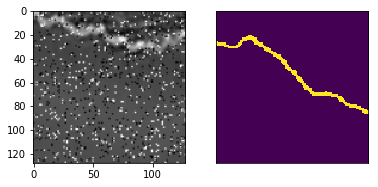

In [33]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.xticks([]), plt.yticks([])
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
axarr[1].imshow(tmp)
plt.show()